Dataset: https://www.kaggle.com/datasets/kausthubkannan/5-flower-types-classification-dataset

# Introduccion


**Problema:** La identificación precisa y rápida de diferentes especies de flores es fundamental en los esfuerzos por conservar la biodiversidad global. Actualmente, este proceso depende en gran medida del reconocimiento manual por parte de expertos, lo que puede ser lento y propenso a errores. Este proyecto busca enfrentar este desafío utilizando un modelo de deep learning capaz de clasificar automáticamente cinco tipos de flores, simplificando así el trabajo de monitoreo y conservación.



**Relevancia:** El desarrollo de una herramienta automatizada para la identificación de flores podría ser un recurso valioso para biólogos y conservacionistas. Ayudaría a agilizar la recopilación de datos sobre la flora de un área, permitiendo una mejor comprensión de los ecosistemas y facilitando la protección de especies amenazadas o en peligro de extinción.

# Datos


El dataset utilizado en este proyecto está compuesto por imágenes de cinco tipos de flores, con un total de 5,000 imágenes, distribuidas equitativamente en 1,000 imágenes por clase.
Los datos se dividieron en un 80% para el conjunto de entrenamiento, un 10% para validación, y un 10% para prueba. Esta división permite un entrenamiento efectivo del modelo, una evaluación continua durante el proceso de ajuste, y una prueba final para medir su rendimiento de manera precisa.

## Descargar librerias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, shutil, pathlib
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import RandomZoom, RandomBrightness, RandomContrast
from keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

## Preparar del dataset

El dataset original está organizado en un directorio que contiene imágenes clasificadas en cinco categorías: Lilly, Lotus, Orchid, Sunflower, y Tulip. Para facilitar la preparación y manejo de los datos para el entrenamiento del modelo, se creó una nueva estructura de directorios utilizando Python. Esta nueva estructura de datos divide las imágenes en conjuntos de entrenamiento, validación y prueba.

In [ ]:
base_dir = pathlib.Path("flowers/flowers_images")

In [ ]:
# Directorio original que contiene las carpetas de cada categoría
original_dir = pathlib.Path("flowers/flower_images")
# Directorio donde se creará la estructura deseada
new_base_dir = pathlib.Path("flowers_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("Lilly", "Lotus", "Orchid", "Sunflower", "Tulip"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)

        # Listar todas las imágenes en la carpeta de la categoría
        image_files = list(original_dir.glob(f"{category}/*.jpg"))

        # Seleccionar el subconjunto necesario
        selected_files = image_files[start_index:end_index]

        for file_path in selected_files:
            shutil.copyfile(src=file_path, dst=dir / file_path.name)

# Divide 800 para entrenamiento, 100 para validación y 100 para prueba por categoría
make_subset("train", start_index=0, end_index=800)
make_subset("validation", start_index=800, end_index=900)
make_subset("test", start_index=900, end_index=1000)


In [ ]:
new_base_dir = pathlib.Path("flowers_small")

Se utilizó la función image_dataset_from_directory de TensorFlow para cargar las imágenes y procesarlas en lotes de 32, con un tamaño uniforme de 180x180 píxeles. Esta función también convierte las etiquetas en un formato entero para que puedan ser utilizadas adecuadamente en la tarea de clasificación.

In [ ]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

train_dataset = train_dataset.map(lambda x, y: (x, tf.cast(y, tf.int32)))
validation_dataset = validation_dataset.map(lambda x, y: (x, tf.cast(y, tf.int32)))
test_dataset = test_dataset.map(lambda x, y: (x, tf.cast(y, tf.int32)))

Found 4000 files belonging to 5 classes.
Found 500 files belonging to 5 classes.
Found 499 files belonging to 5 classes.


Hacemos un for para poder visualizar las imagenes del dataset con su debida clasificacion.

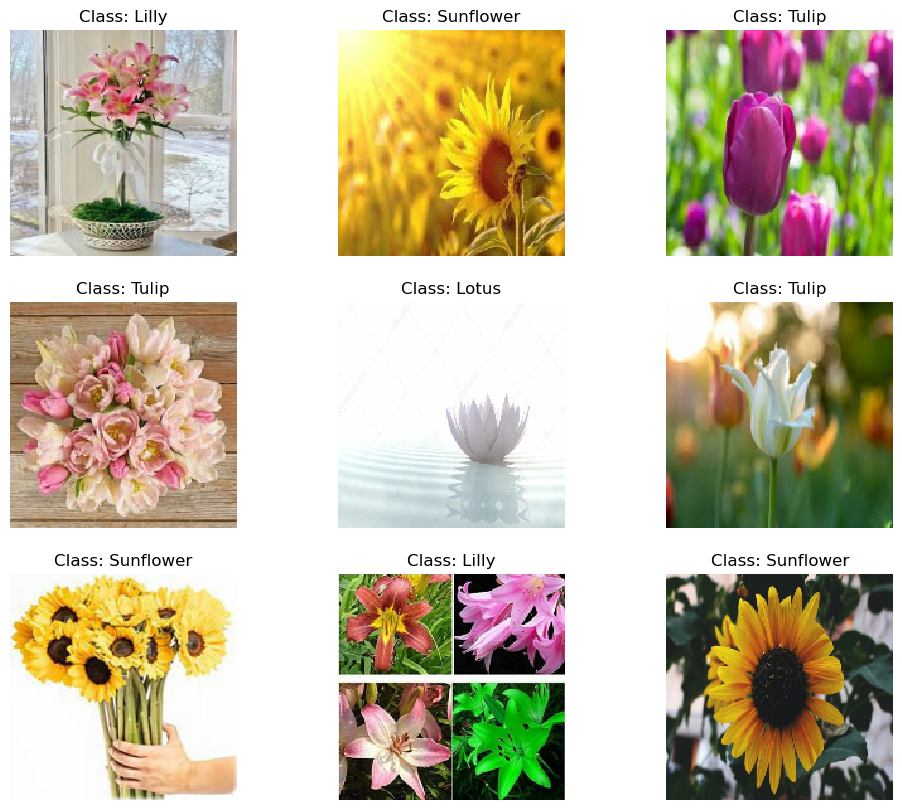

In [ ]:
class_names = ["Lilly", "Lotus", "Orchid", "Sunflower", "Tulip"]

plt.figure(figsize=(12, 10))
index = 0
for element in train_dataset.take(1):
  for i in range(9):
    image = element[0][i]
    label = element[1][i].numpy()
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image/255, interpolation="nearest")
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

# Arquitectura del modelo
Se implementó la clase ResidualUnit, que nos sirve para construir bloques residuales en una arquitectura de red neuronal profunda. Estas unidades son clave para resolver un problema conocido en redes profundas: la "degradación del rendimiento."


El uso de SeparableConv2D dentro de la ResidualUnit optimiza aún más el modelo al reducir el número de parámetros y la carga computacional. La combinación de capas convolucionales separables y la normalización por lotes garantiza que el flujo de datos sea estable y rápido. Además, la función de activación ReLU ayuda a mantener la no linealidad necesaria para que el modelo aprenda relaciones complejas entre las características de las imágenes.

In [ ]:
class ResidualUnit(keras.layers.Layer):  # Extiende la clase base Layer de Keras
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)  # Llama al constructor de la clase Layer
        self.activation = keras.activations.get(activation)  # Obtiene la función de activación (ReLU por defecto)

        # Capas principales del bloque residual
        self.main_layers = [
            # Capa SeparableConv2D: separa la convolución en una profundidad y una de punto, aumentando la eficiencia
            keras.layers.SeparableConv2D(filters, 3, strides=strides,
                                         padding="same", use_bias=False),
            keras.layers.BatchNormalization(),  # Normaliza las activaciones para estabilizar el entrenamiento
            self.activation,  # Aplica la función de activación para introducir no linealidad
            # Segunda capa SeparableConv2D: misma idea que la primera pero sin reducir dimensiones
            keras.layers.SeparableConv2D(filters, 3, strides=1,
                                         padding="same", use_bias=False),
            keras.layers.BatchNormalization()  # Otra capa de normalización por lotes
        ]

        # Capas de la conexión de atajo (skip connection) para redimensionar la entrada si es necesario
        self.skip_layers = []
        if strides > 1:  # Si los strides son mayores a 1, redimensiona la entrada
            self.skip_layers = [
                keras.layers.SeparableConv2D(filters, 1, strides=strides,  # Convolución 1x1 para ajustar dimensiones
                                             padding="same", use_bias=False),
                keras.layers.BatchNormalization()  # Normalización por lotes para mantener la estabilidad
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:  # Aplica las capas principales del bloque residual
            Z = layer(Z)
        skip_Z = inputs  # Conexión de atajo que pasa la entrada original sin cambios
        for layer in self.skip_layers:  # Aplica las capas de la conexión de atajo si es necesario
            skip_Z = layer(skip_Z)
        # Suma las salidas del camino principal y del atajo, y aplica la función de activación
        return self.activation(Z + skip_Z)


El modelo diseñado para la clasificación de imágenes de flores sigue una arquitectura inspirada en ResNet, utilizando bloques residuales para optimizar el flujo de gradientes y facilitar el aprendizaje profundo. La implementación comienza con una red secuencial en Keras, donde se aplican diversas técnicas de procesamiento de imágenes y optimización de la arquitectura.

In [ ]:
model = keras.models.Sequential()  # Se crea un modelo secuencial de Keras

model.add(keras.layers.Input(shape=(180, 180, 3)))  # Capa de entrada que recibe imágenes RGB de 180x180 píxeles

# Capa de convolución inicial: extrae características básicas de las imágenes
model.add(keras.layers.Conv2D(64, 7, strides=2, padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())  # Normaliza las activaciones para estabilizar y acelerar el entrenamiento
model.add(keras.layers.Activation("relu"))  # Aplica la activación ReLU para introducir no linealidad
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))  # Reduce las dimensiones espaciales

# Bloques residuales: se añaden múltiples bloques para aprender características complejas
prev_filters = 64
for filters in [64] * 2 + [128] * 2 + [256] * 2:
    strides = 1 if filters == prev_filters else 2  # Aumenta los strides cuando cambia el número de filtros
    model.add(ResidualUnit(filters, strides=strides))  # Añade el bloque residual personalizado
    prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())  # Realiza el agrupamiento global, promediando las características

model.add(keras.layers.Dropout(0.5))  # Aplica Dropout para prevenir el sobreajuste

# Capa de salida: produce una distribución de probabilidad para las 5 clases
model.add(keras.layers.Dense(5, activation="softmax"))

# Compilación del modelo: se define el optimizador y la función de pérdida
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


Para optimizar el entrenamiento del modelo y prevenir problemas como el sobreajuste o el tiempo de entrenamiento excesivo, se implementan dos callbacks de Keras: EarlyStopping y ModelCheckpoint. Estas herramientas permiten gestionar el proceso de entrenamiento de manera más eficiente y segura.

In [ ]:
# Definir el callback de EarlyStopping
early_stopping = EarlyStopping(
    monitor="val_loss",         # Se monitorea la pérdida en el conjunto de validación
    patience=3,                 # Si la pérdida no mejora en 3 épocas consecutivas, se detiene el entrenamiento
    restore_best_weights=True   # Restaura los pesos del modelo con el mejor rendimiento en validación
)

# Definir el callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    filepath="resnet_dsc.keras",  # Ruta donde se guardará el mejor modelo
    save_best_only=True,          # Guarda solo el modelo con la mejor pérdida de validación
    monitor="val_loss"            # Monitorea la pérdida en el conjunto de validación para determinar el mejor modelo
)

Procedemos a entrenar el modelo

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="resnet_dsc.keras", save_best_only=True, monitor="val_loss")]

history = model.fit(train_dataset, epochs=20,
                    validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 52s 361ms/step - accuracy: 0.3814 - loss: 1.6263 - val_accuracy: 0.2000 - val_loss: 1.6115
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 352ms/step - accuracy: 0.5144 - loss: 1.2315 - val_accuracy: 0.2000 - val_loss: 1.6246
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 394ms/step - accuracy: 0.5902 - loss: 1.0905 - val_accuracy: 0.2760 - val_loss: 1.5165
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 371ms/step - accuracy: 0.6217 - loss: 0.9768 - val_accuracy: 0.4580 - val_loss: 1.1862
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 353ms/step - accuracy: 0.6666 - loss: 0.8734 - val_accuracy: 0.3900 - val_loss: 1.7336
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 355ms/step - accuracy: 0.6730 - loss: 0.8405 - val_accuracy: 0.5960 - val_loss: 1.0251
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 357ms/step - accuracy: 0.7335 - loss: 0.6869 - val_accuracy: 0.6080 - val_loss: 1.1096
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 351ms/step - accuracy: 0.7562 - loss: 0

In [ ]:
model.save("modelo/el_modelo.keras")

## Interpretación de los datos

**Pérdida de entrenamiento vs. pérdida de validación:** La primera gráfica muestra que la pérdida de entrenamiento disminuye de manera constante, lo que indica que el modelo está aprendiendo a adaptarse a los datos de entrenamiento. Pero, la pérdida en lugar de mejorar, varia considerablemente y aumenta después de algunas épocas. Esto es un signo claro de overfitting.

**Precisión de entrenamiento vs. precisión de validación:** La segunda gráfica muestra que la precisión del entrenamiento mejora continuamente, alcanzando niveles altos. Aunque la precisión de validación también aumenta al principio, se estabiliza y comienza a variar después de unas pocas épocas. La diferencia evidente entre la precisión del entrenamiento y la de validación confirma el overfitting.

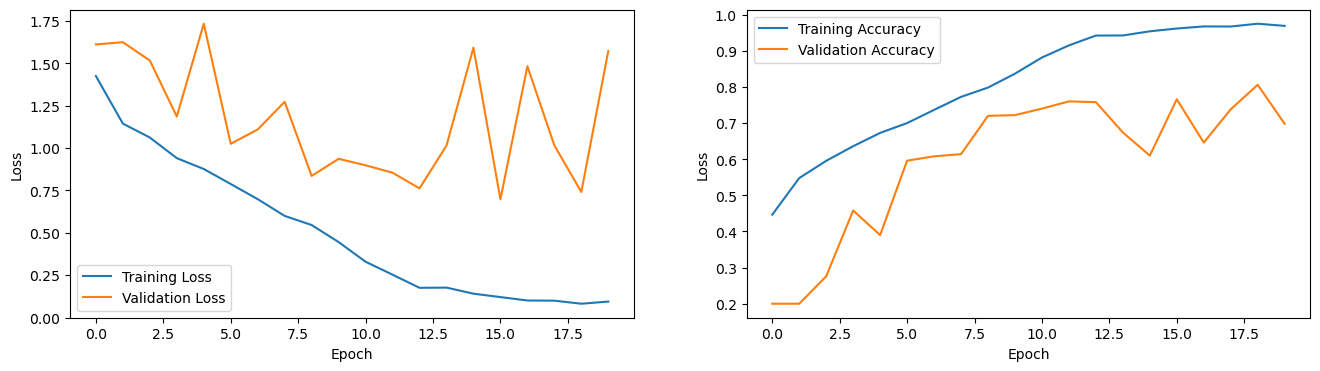

In [ ]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

 La precisión es moderada y refleja que, aunque el modelo ha aprendido algunas características relevantes para la tarea de clasificación, su rendimiento podría no ser suficiente para imagenes más exigentes.

In [ ]:
# model = keras.models.load_model("resnet_dsc.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6484 - loss: 1.6026
Test accuracy: 0.645


Creamos una funcion para poder probar el modelo creado con una imagen de nuestro directorio.

In [ ]:
def predict_image(img_path, model, class_names):
    img = load_img(img_path, target_size=(180, 180))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    predictions = model.predict(img_array)[0]  # Obtener las probabilidades para cada clase
    predictions_percentage = predictions * 100  # Convertir a porcentajes

    # Crear un string formateado para el output de predicción
    prediction_output = ", ".join([f"{class_name}: {prob:.2f}%" for class_name, prob in zip(class_names, predictions_percentage)])
    print(f"Raw prediction output: [{prediction_output}]")

    predicted_class_index = np.argmax(predictions)
    predicted_class_name = class_names[predicted_class_index]
    print(f"La imagen es un: {predicted_class_name}")

    return predicted_class_name, predictions_percentage


Se probaron imagenes de cada una de nuestras clases, pero el modelo no logro clasificar correctamente, solamente una. Esto indica un evidente sesgo en el entrenamiento y/o dificultades en la capacidad del modelo para distinguir correctamente entre las clases

In [ ]:
resultado = predict_image('TestUsuario/Sunflower.jpg', model, class_names)
resultado = predict_image('TestUsuario/Lotus.jpg', model, class_names)
resultado = predict_image('TestUsuario/Orchid.jpg', model, class_names)
resultado = predict_image('TestUsuario/Lilly.jpg', model, class_names)
resultado = predict_image('TestUsuario/Tulip.jpg', model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Raw prediction output: [[0.20078191 0.29451945 0.17681916 0.1363368  0.19154266]]
La imagen es un: Lotus


# Ajuste del modelo

Sabiendo que el modelo anterior mostró signos de overfitting y dificultades para generalizar correctamente a nuevos datos, se implementaron mejoras con el objetivo de optimizar su rendimiento y capacidad de aprendizaje.

Volvemos a cargar los datos.

In [ ]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=64)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=64)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=64)

train_dataset = train_dataset.map(lambda x, y: (x, tf.cast(y, tf.int32)))
validation_dataset = validation_dataset.map(lambda x, y: (x, tf.cast(y, tf.int32)))
test_dataset = test_dataset.map(lambda x, y: (x, tf.cast(y, tf.int32)))

Found 4000 files belonging to 5 classes.
Found 500 files belonging to 5 classes.
Found 499 files belonging to 5 classes.


 Una de las estrategias empleadas fue la adición de un SEBlock (Squeeze-and-Excitation Block) a la arquitectura ResNet.

El SEBlock (Squeeze-and-Excitation Block) es una mejora en las redes neuronales profundas que permite al modelo aprender la importancia de cada canal de características y ajustar sus pesos de manera dinámica. En palabras mas generales, aplica un mecanismo de atención a las características aprendidas por las capas convolucionales, destacando las características más relevantes para la tarea de clasificación.

In [ ]:
class SEBlock(keras.layers.Layer):
    def __init__(self, filters, ratio=16):
        super(SEBlock, self).__init__()
        self.filters = filters
        self.ratio = ratio
        # Capa de Global Average Pooling: reduce las dimensiones espaciales a un vector de características por canal
        self.global_avg_pool = keras.layers.GlobalAveragePooling2D()
        # Primera capa densa: reduce dimensionalidad según el ratio y aplica ReLU
        self.dense1 = keras.layers.Dense(filters // ratio, activation='relu', use_bias=False)
        # Segunda capa densa: restaura la dimensionalidad original y aplica la activación sigmoide
        self.dense2 = keras.layers.Dense(filters, activation='sigmoid', use_bias=False)

    def call(self, inputs):
        se = self.global_avg_pool(inputs)  # Reduce las dimensiones espaciales
        se = keras.layers.Reshape((1, 1, self.filters))(se)  # Reshape para ajustar el tensor al tamaño correcto
        se = self.dense1(se)  # Reducción de dimensionalidad con ReLU
        se = self.dense2(se)  # Restauración de dimensionalidad con una activación sigmoide
        # Multiplica las características recalibradas con las originales
        return keras.layers.Multiply()([inputs, se])


In [ ]:
class ResidualUnit(keras.layers.Layer):  # Extiende la clase base Layer de Keras
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)  # Llama al constructor de la clase Layer
        self.activation = keras.activations.get(activation)  # Obtiene la función de activación (ReLU por defecto)

        # Capas principales del bloque residual
        self.main_layers = [
            # Primera capa Conv2D: usa un kernel de 3x3, padding "same", sin sesgo, y regularización L2
            keras.layers.Conv2D(filters, 3, strides=strides,
                                padding="same", use_bias=False,
                                kernel_regularizer=regularizers.l2(0.001)),
            keras.layers.BatchNormalization(),  # Normalización por lotes para estabilizar las activaciones
            self.activation,  # Aplicación de la función de activación
            # Segunda capa Conv2D: también usa un kernel de 3x3 y regularización L2
            keras.layers.Conv2D(filters, 3, strides=1,
                                padding="same", use_bias=False,
                                kernel_regularizer=regularizers.l2(0.001)),
            keras.layers.BatchNormalization()  # Otra capa de normalización por lotes
        ]

        # Capas de la conexión de atajo (skip connection) para redimensionar la entrada si es necesario
        self.skip_layers = []
        if strides > 1:  # Si los strides son mayores a 1, redimensiona la entrada
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides,  # Convolución 1x1 para ajustar dimensiones
                                    padding="same", use_bias=False,
                                    kernel_regularizer=regularizers.l2(0.001)),
                keras.layers.BatchNormalization()  # Normalización por lotes
            ]

        # SEBlock: Se añade el bloque de atención Squeeze-and-Excitation
        self.se_block = SEBlock(filters)

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:  # Aplica las capas principales del bloque residual
            Z = layer(Z)
        Z = self.se_block(Z)  # Aplica el SEBlock para recalibrar las características
        skip_Z = inputs
        for layer in self.skip_layers:  # Aplica las capas de la conexión de atajo si es necesario
            skip_Z = layer(skip_Z)
        # Suma las salidas del camino principal y del atajo, y aplica la función de activación
        return self.activation(Z + skip_Z)


Se  aplico data augmentation para tratar de disminuir el overfitting que mostraba el modelo. Este bloque de data augmentation se aplica durante el entrenamiento para generar variaciones en las imágenes y prevenir que el modelo se sobreajuste a las características específicas del conjunto de datos de entrenamiento.

In [ ]:
data_augmentation = tf.keras.Sequential([
    RandomZoom(0.2),                          # Zoom aleatorio en un rango de 20%
    RandomBrightness(0.2),                    # Ajuste de brillo aleatorio en un rango de 20%
    RandomContrast(0.2),                      # Ajuste de contraste aleatorio en un rango de 20%
], name='data_augmentation')

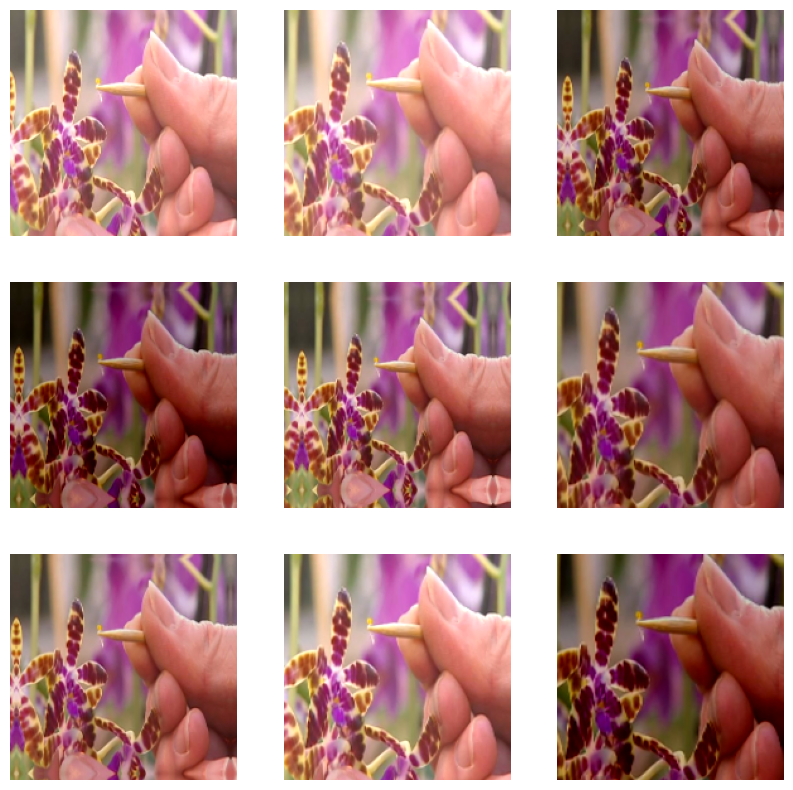

In [ ]:
# Visualizar algunas imágenes aumentadas
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)  # Aplicar augmentación
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

Cambios al modelo para mejorar el ajuste
- **Regularización L2:** Esta técnica penaliza los pesos grandes y ayuda a prevenir el overfitting al mantener la magnitud de los pesos bajo control.
- **Dropout:** Se añadió una capa de Dropout con una tasa de 0.5 antes de la capa de salida. Esto apaga aleatoriamente un 50% de las unidades durante el entrenamiento, evitando que el modelo dependa excesivamente de ciertas neuronas y mejorando la generalización.
- **Reducción de la cantidad de filtros en los bloques residuales:** Esto simplifica la red al disminuir el número de filtros y bloques, reduciendo la complejidad del modelo y ayudando a evitar el sobreajuste.
- **Uso de SeparableConv2D en los bloques residuales:**  Es más eficiente que Conv2D en términos computacionales y ayuda a reducir el número de parámetros del modelo, lo que es útil para mitigar el overfitting.
- **Optimizador Adam:** Se configuró el optimizador Adam con una tasa de aprendizaje pequeña (0.0001) para un ajuste más cuidadoso de los pesos. Esto ayuda a evitar oscilaciones y convergencia prematura, lo que puede contribuir al overfitting.

In [ ]:
# Crear modelo
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(180, 180, 3)))

# ResNet (sin añadir capas adicionales)
model.add(data_augmentation)
model.add(keras.layers.Conv2D(32, 7, strides=2, padding="same", use_bias=False, kernel_regularizer=regularizers.l2(0.1)))  # Regularización L2
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
# model.add(keras.layers.Dropout(0.6))  # Dropout adicional

prev_filters = 64
for filters in [32] * 2 + [64] * 1:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))  # Regularización ya aplicada internamente
    prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Dropout(0.5))  # Dropout en la capa de salida

# Capa de salida para 15 clases
model.add(keras.layers.Dense(15, activation="softmax"))


In [ ]:
optimizer = Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)

# Compilar el modelo
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Configurar callback para guardar el mejor modelo
callbacks = [
    ModelCheckpoint(filepath="mobilenet_best_model.keras", save_best_only=True, monitor="val_loss")
]

# Entrenar el modelo
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 218ms/step - accuracy: 0.6830 - loss: 1.2847 - val_accuracy: 0.6120 - val_loss: 1.4039
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - accuracy: 0.6938 - loss: 1.2437 - val_accuracy: 0.6780 - val_loss: 1.2364
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - accuracy: 0.7037 - loss: 1.2271 - val_accuracy: 0.6820 - val_loss: 1.2535
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - accuracy: 0.6940 - loss: 1.2440 - val_accuracy: 0.7040 - val_loss: 1.2162
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - accuracy: 0.7055 - loss: 1.2307 - val_accuracy: 0.7320 - val_loss: 1.1358
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - accuracy: 0.6954 - loss: 1.1969 - val_accuracy: 0.6460 - val_loss: 1.3176
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - accuracy: 0.7131 - loss: 1.1858 - val_accuracy: 0.7080 - val_loss: 1.1732
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - accuracy: 0.6976 - loss: 1.1823 - val_accu

In [ ]:
model.save("modelo/el_segundo_modelo.keras")

## Resultados

En resumen, las mejoras realizadas han hecho que el modelo sea más equilibrado, con una mejor precisión en la validación y una pérdida que, aunque todavía necesita ajuste, es menos problemática y más manejable. Estos cambios demuestran que el modelo ha ganado en términos de robustez y capacidad de generalización. La precisión en el conjunto de prueba aumentó a 0.689, lo que representa una mejora respecto al modelo anterior y refleja un mejor rendimiento general.



Sin embargo, a pesar de estas mejoras, el modelo sigue mostrando un problema al probar con nuevas imágenes, ya que clasifica todas las imágenes como la clase Lotus. Esto sugiere que el modelo aún enfrenta dificultades con la capacidad de discriminación entre clases, posiblemente debido a un sesgo en el aprendizaje o la necesidad de un preprocesamiento más refinado.

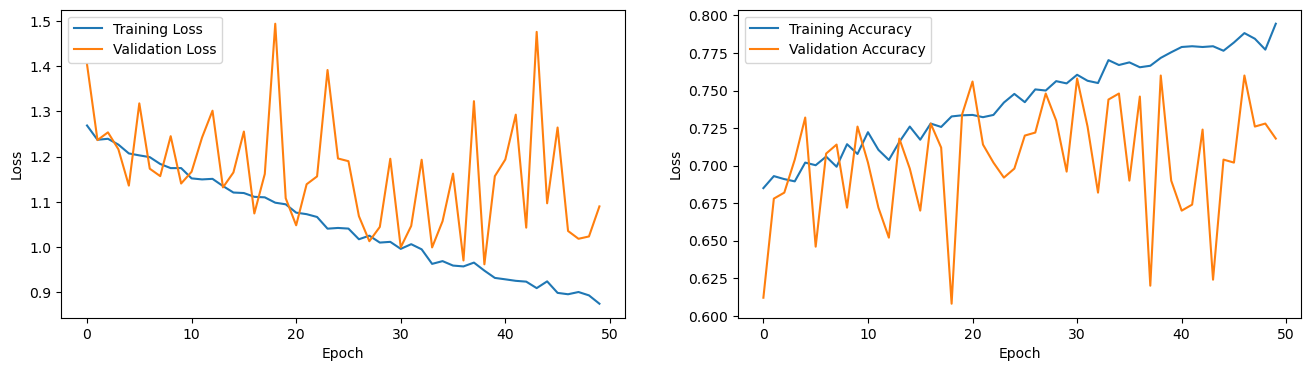

In [ ]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# model = keras.models.load_model("resnet_dsc.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6847 - loss: 1.1649
Test accuracy: 0.689


In [ ]:
# Uso de la función
resultado = predict_image('TestUsuario/Sunflower.jpg', model, class_names)
resultado = predict_image('TestUsuario/Lotus.jpg', model, class_names)
resultado = predict_image('TestUsuario/Orchid.jpg', model, class_names)
resultado = predict_image('TestUsuario/Lilly.jpg', model, class_names)
resultado = predict_image('TestUsuario/Tulip.jpg', model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Raw prediction output: [Lilly: 9.84%, Lotus: 54.46%, Orchid: 11.70%, Sunflower: 1.23%, Tulip: 22.11%]
La imagen es un: Lotus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Raw prediction output: [Lilly: 9.79%, Lotus: 54.67%, Orchid: 11.68%, Sunflower: 1.22%, Tulip: 21.99%]
La imagen es un: Lotus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Raw prediction output: [Lilly: 9.79%, Lotus: 54.59%, Orchid: 11.71%, Sunflower: 1.22%, Tulip: 22.03%]
La imagen es un: Lotus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Raw prediction output: [Lilly: 9.85%, Lotus: 54.36%, Orchid: 11.76%, Sunflower: 1.24%, Tulip: 22.12%]
La imagen es un: Lotus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Raw prediction output: [Lilly: 9.77%, Lotus: 54.44%, Orchid: 11.78%, Sunflower: 1.23%, Tulip: 22.13%]
La imagen es un: Lotus


# Conclusiones

En este proyecto, se desarrolló e implementó un modelo de deep learning para la clasificación de cinco tipos de flores, me enfrente a desafíos  como el overfitting y la limitada capacidad de generalización. Se realizaron varias mejoras, que resultaron en un modelo más robusto y con un mejor rendimiento general. Estas modificaciones llevaron a un aumento en la precisión del conjunto de prueba, alcanzando un 68.9%, lo que representa un progreso en comparación con la versión inicial del modelo.

Desafortunadamente, a pesar de estas optimizaciones, aun persisten ciertos problemas, como el hecho de que el modelo clasifique todas las imágenes de prueba como una sola clase (Lotus). Esto sugiere que aún se necesita un ajuste más detallado. Además, podría ser necesario experimentar con arquitecturas más sofisticadas o métodos adicionales para mejorar la precisión.

Finalmente, aunque se lograron avances significativos, el modelo aun tiene cosas que mejorar. Esto nos dice la importancia de un preprocesamiento adecuado, técnicas de regularización efectivas, y la necesidad de un análisis continuo para ajustar y mejorar el rendimiento del modelo.